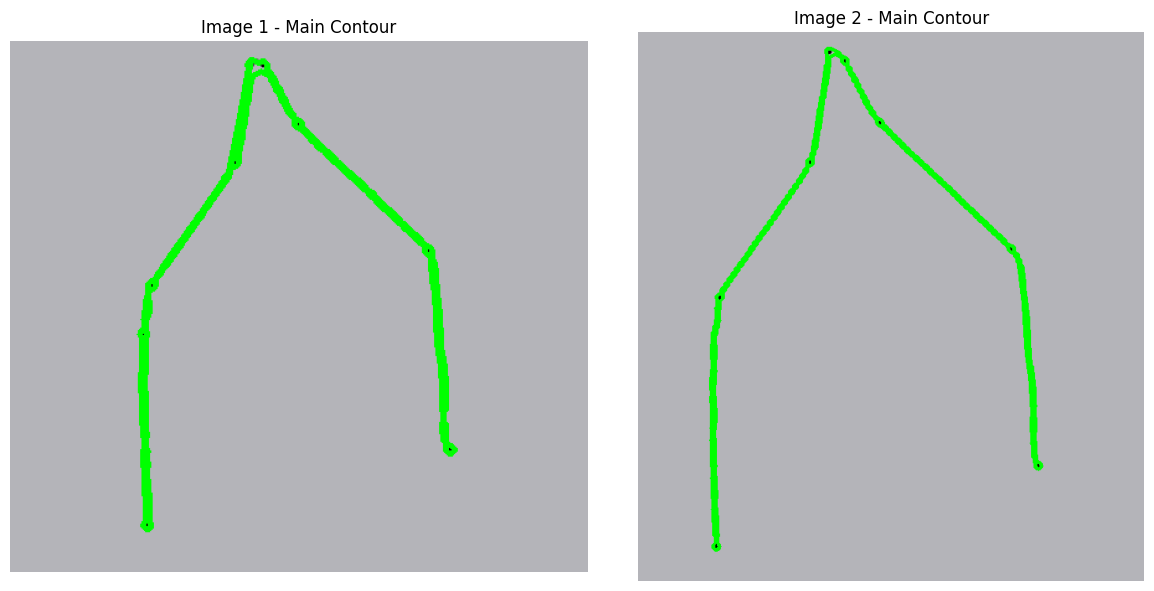

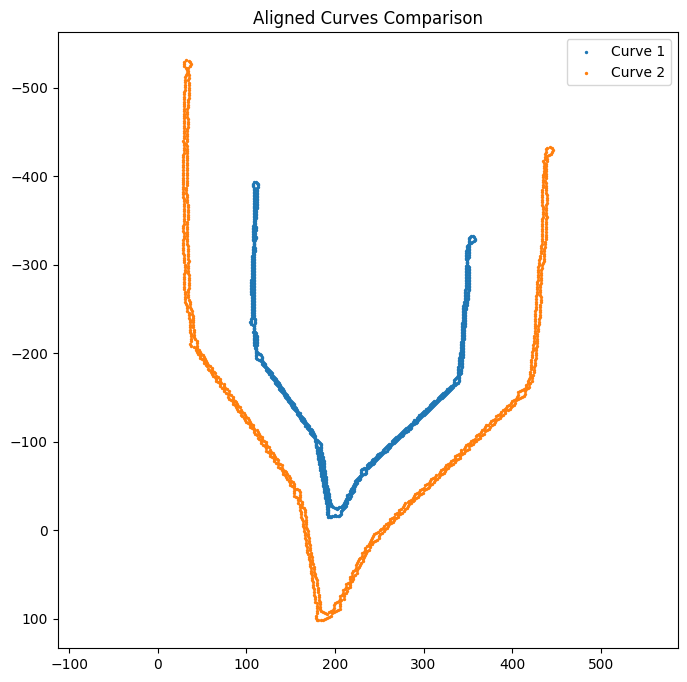


相似度评估结果:
平均点距: 117.87 pixels
Hausdorff距离: 157.97 pixels
Hu矩差异: 4.0550 (越小越相似)

相似度评估结果:
0.0060511111573932665 164.25890435481372


In [84]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.spatial.distance import directed_hausdorff

# ================== 核心功能函数 ==================
def extract_contours(img_path, max_value=255):
    """改进的轮廓提取函数"""
    # 读取图像
    color_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if color_img is None:
        raise ValueError(f"图像读取失败: {img_path}")

    # 预处理
    gray = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (7,7), 2)

    # 自适应阈值
    binary = cv2.adaptiveThreshold(
        gray, max_value, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 21, 4
    )

    # 形态学操作
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=3)

    # 查找轮廓
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return contours, color_img, binary

def merge_close_contours(contours, distance_threshold=100):
    """智能合并相邻轮廓"""
    if not contours:
        return []

    # 将轮廓转换为点集形式
    contours = [cnt.reshape(-1,2) for cnt in contours]
    merged = []
    used = [False] * len(contours)

    for i in range(len(contours)):
        if used[i]:
            continue

        current = contours[i]
        used[i] = True

        # 寻找可合并的相邻轮廓
        while True:
            found = False
            for j in range(len(contours)):
                if used[j]:
                    continue

                # 检查端点距离
                last_point = current[-1]
                dist_to_start = np.linalg.norm(last_point - contours[j][0])
                dist_to_end = np.linalg.norm(last_point - contours[j][-1])

                if min(dist_to_start, dist_to_end) < distance_threshold:
                    # 选择距离更近的连接方式
                    if dist_to_start < dist_to_end:
                        current = np.vstack([current, contours[j]])
                    else:
                        current = np.vstack([current, contours[j][::-1]])
                    used[j] = True
                    found = True
                    break
            if not found:
                break
        merged.append(current)
    return [cnt.reshape(-1,1,2) for cnt in merged]

def select_main_contour(contours):
    """自动选择面积最大的轮廓"""
    if not contours:
        raise ValueError("没有检测到任何轮廓")
    areas = [cv2.contourArea(cnt) for cnt in contours]
    return contours[np.argmax(areas)]

def resample_curve(points, num_samples=1000):
    """改进的重采样函数"""
    if points.ndim == 3:
        points = points.reshape(-1,2)

    # 计算累积弧长
    diffs = np.diff(points, axis=0)
    seg_lengths = np.linalg.norm(diffs, axis=1)
    total_length = np.sum(seg_lengths)
    if total_length == 0:
        return points

    # 生成采样位置
    sample_distances = np.linspace(0, total_length, num_samples)

    # 线性插值
    resampled = []
    current_seg = 0
    accumulated = 0.0

    for dist in sample_distances:
        while current_seg < len(seg_lengths) and \
              accumulated + seg_lengths[current_seg] < dist:
            accumulated += seg_lengths[current_seg]
            current_seg += 1

        if current_seg >= len(seg_lengths):
            resampled.append(points[-1])
            continue

        t = (dist - accumulated) / seg_lengths[current_seg]
        p = (1-t)*points[current_seg] + t*points[current_seg+1]
        resampled.append(p)

    return np.array(resampled)

def align_curves(curve1, curve2):
    """Procrustes对齐"""
    # 中心化
    c1_mean = np.mean(curve1, axis=0)
    c2_mean = np.mean(curve2, axis=0)
    c1 = curve1 - c1_mean
    c2 = curve2 - c2_mean

    # 奇异值分解求旋转矩阵
    H = c2.T @ c1
    U, _, Vt = np.linalg.svd(H)
    R = U @ Vt

    # 应用变换
    aligned_c2 = (c2 @ R.T) + c1_mean
    return c1 + c1_mean, aligned_c2

def compute_similarity(curve1, curve2):
    """综合相似度评估"""
    # 重采样对齐
    c1 = resample_curve(curve1, 1000)
    c2 = resample_curve(curve2, 1000)
    c1, c2 = align_curves(c1, c2)

    # 平均距离
    distances = np.linalg.norm(c1 - c2, axis=1)
    avg_dist = np.mean(distances)

    # Hausdorff距离
    hd_dist = max(
        directed_hausdorff(c1, c2)[0],
        directed_hausdorff(c2, c1)[0]
    )

    # Hu矩相似度
    def get_hu_moments(curve):
        moments = cv2.moments(curve.astype(np.float32))
        return cv2.HuMoments(moments)

    hu1 = get_hu_moments(c1)
    hu2 = get_hu_moments(c2)
    hu_diff = np.sum(np.abs(np.log(np.abs(hu1)) - np.log(np.abs(hu2))))

    return {
        'average_distance': avg_dist,
        'hausdorff_distance': hd_dist,
        'hu_similarity': hu_diff
    }
def compute_similarity_abs(curve1, curve2, num_samples=1000):
    """
    对两条曲线做等数量重采样后，计算平均点对点距离和简单相似度得分
    - curve1, curve2: (N,2)/(M,2)形状的坐标
    - num_samples: 重采样的点数
    返回: (avg_dist, similarity_score)
    """
    # 重采样
    c1 = resample_curve(curve1, num_samples)
    c2 = resample_curve(curve2, num_samples)

    # 点对应的欧几里得距离
    distances = np.sqrt(np.sum((c1 - c2)**2, axis=1))
    avg_dist = np.mean(distances)

    # 简单相似度(0 ~ 1)，值越接近1表示越相似
    similarity_score = 1.0 / (1.0 + avg_dist)

    return avg_dist, similarity_score

# ================== 可视化函数 ==================
def draw_contour_comparison(img1, cnt1, img2, cnt2):
    """绘制轮廓对比图"""
    plt.figure(figsize=(12,6))

    # 图像1
    plt.subplot(1,2,1)
    vis1 = cv2.drawContours(img1.copy(), [cnt1], -1, (0,255,0), 3)
    plt.imshow(cv2.cvtColor(vis1, cv2.COLOR_BGR2RGB))
    plt.title('Image 1 - Main Contour')
    plt.axis('off')

    # 图像2
    plt.subplot(1,2,2)
    vis2 = cv2.drawContours(img2.copy(), [cnt2], -1, (0,255,0), 3)
    plt.imshow(cv2.cvtColor(vis2, cv2.COLOR_BGR2RGB))
    plt.title('Image 2 - Main Contour')
    plt.axis('off')

    plt.tight_layout()

def plot_aligned_curves(curve1, curve2):
    """绘制对齐后的曲线"""
    c1 = resample_curve(curve1, 1000)
    c2 = resample_curve(curve2, 1000)
    c1, c2 = align_curves(c1, c2)

    plt.figure(figsize=(8,8))
    plt.scatter(c1[:,0], -c1[:,1], s=2, label='Curve 1')
    plt.scatter(c2[:,0], -c2[:,1], s=2, label='Curve 2')
    plt.gca().invert_yaxis()
    plt.legend()
    plt.title("Aligned Curves Comparison")
    plt.axis('equal')
    plt.show()

# ================== 主流程 ==================
def main(img_path1, img_path2):
    # 1. 提取并处理轮廓
    contours1, color_img1, binary1 = extract_contours(img_path1)
    contours2, color_img2, binary2 = extract_contours(img_path2)

    # 2. 合并相邻轮廓
    merged1 = merge_close_contours(contours1)
    merged2 = merge_close_contours(contours2)

    # 3. 自动选择主轮廓
    main_cnt1 = select_main_contour(merged1)
    main_cnt2 = select_main_contour(merged2)

    # 4. 可视化
    draw_contour_comparison(color_img1, main_cnt1, color_img2, main_cnt2)
    plot_aligned_curves(main_cnt1, main_cnt2)

    # 5. 计算相似度
    similarity = compute_similarity(main_cnt1, main_cnt2)

    print("\n相似度评估结果:")
    print(f"平均点距: {similarity['average_distance']:.2f} pixels")
    print(f"Hausdorff距离: {similarity['hausdorff_distance']:.2f} pixels")
    print(f"Hu矩差异: {similarity['hu_similarity']:.4f} (越小越相似)")

    _,similarity2 = compute_similarity_abs(main_cnt1, main_cnt2,100)
    #avg_dist, similarity_score
    print("\n相似度评估结果:")
    print(similarity2,_)
    #print(f"评分: {similarity2['similarity_score']:.2f} ")


if __name__ == "__main__":
    # 设置图像路径
    img1 = "p3.png"
    img2 = "p4.png"

    # 执行主流程
    main(img1, img2)